# Assignment 1: Language modelling

In this assignment you will implement and train two or three neural language models: the fixed-window model, the recurrent neural network model from Unit&nbsp;1-2, and optionally a model based on the Transformer architecture from Unit&nbsp;1-3. You will evaluate these models by computing their perplexity on a benchmark dataset.

In [90]:
import torch

For this lab, you should use the GPU if you have one:

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    # NVIDIA
# device = torch.device('mps')    # Apple Silicon
device

device(type='cuda')

## Data

The data for this assignment is [WikiText](https://blog.salesforceairesearch.com/the-wikitext-long-term-dependency-language-modeling-dataset/), a collection of more than 100 million tokens extracted from the “Good” and “Featured” articles on Wikipedia. We will use the small version of the dataset, which contains slightly more than 2.5 million tokens.

The next cell contains code for an object that will act as a container for the “training” and the “validation” section of the data. We fill this container by reading the corresponding text files. The only processing we do is to whitespace-tokenise and to replace each newline with an end-of-sentence token.

In [92]:
UNK = "<unk>"

class WikiText(object):

    def __init__(self):
        self.word2idx = {}
        self.idx2word = []
        self.train = self.read_data('wiki.train.tokens')
        self.valid = self.read_data('wiki.valid.tokens')

    def read_data(self, path):
        ids = []
        with open(path, encoding='utf-8') as source:
            for line in source:
                for word in line.split() + ['<eos>']:
                    if word not in self.word2idx:
                        self.word2idx[word] = len(self.word2idx)
                        self.idx2word.append(word)
                    ids.append(self.word2idx[word])
        return ids
    
    def __len__(self):
        return len(self.idx2word)

The cell below loads the data and prints the total number of tokens and the size of the vocabulary.

In [93]:
wikitext = WikiText()
UNK_IDX = wikitext.word2idx[UNK]

print('Tokens in train:', len(wikitext.train))
print('Tokens in valid:', len(wikitext.valid))
print('Vocabulary size:', len(wikitext.word2idx))

Tokens in train: 2088628
Tokens in valid: 217646
Vocabulary size: 33278


## Problem 1: Fixed-window model

In this section, you will implement and train the fixed-window neural language model proposed by [Bengio et al. (2003)](http://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) and presented in the lectures. Recall that an input to the network takes the form of a vector of $n-1$ integers representing the preceding words. Each integer is mapped to a vector via an embedding layer. (All positions share the same embedding.) The embedding vectors are then concatenated and sent through a two-layer feed-forward network with a non-linearity in the form of a rectified linear unit (ReLU) and a final softmax layer.

### Problem 1.1: Vectorise the data

Your first task is to write code for transforming the data in the WikiText container into a vectorised form that can be fed to the fixed-window model. Concretely, you will implement a [collate function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) in the form of a callable vectoriser object. Complete the skeleton code in the cell below:

In [94]:
class FixedWindowVectorizer(object):
    def __init__(self, n):
        self.n = n

    def __call__(self, data):

        X = []
        y = []
        for i in range(len(data) - self.n + 1):
            ngram = data[i:i+self.n]
            X.append(ngram[:-1])
            y.append(ngram[-1])
        return torch.tensor(X), torch.tensor(y)

Your code should implement the following specification:

**__init__** (*self*, *n*)

> Creates a new vectoriser with n-gram order $n$. Your code should be able to handle arbitrary n-gram orders $n \geq 1$.

**__call__** (*self*, *data*)

> Transforms WikiText *data* (a list of word ids) into a pair of tensors $\mathbf{X}$, $\mathbf{y}$ that can be used to train the fixed-window model. Let $N$ be the total number of $n$-grams from the token list; then $\mathbf{X}$ is a matrix with shape $(N, n-1)$ and $\mathbf{y}$ is a vector with length $N$.

#### 🤞 Test your code

Test your implementation by running the code in the next cell. Does the output match your expectation?

In [95]:
valid_x, valid_y = FixedWindowVectorizer(3)(wikitext.valid)

print(valid_x.shape, valid_y.shape)

torch.Size([217644, 2]) torch.Size([217644])


### Problem 1.2: Implement the model

Your next task is to implement the fixed-window model based on the graphical specification given in the lecture.

In [96]:
import torch.nn as nn

class FixedWindowModel(nn.Module):
    def __init__(self, n, n_words, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(n_words, embedding_dim)
        self.n = n-1
        self.head = nn.Sequential(
            nn.Linear(embedding_dim * self.n, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_words)
        )
        

    def forward(self, x):
        batch, *_ = x.shape
        x = self.embedding(x).view(batch, -1)
        return self.head(x)
    
    def generate(self, context, n=10, temperature=1.0):
        self.eval()
        device = next(self.parameters()).device
        if len(context) < self.n:
            context = torch.cat([torch.full((self.n - len(context),), UNK_IDX, dtype=torch.long), context])
        with torch.no_grad():
            context = context[-self.n:].to(device)
            for _ in range(n):
                logits = self(context.unsqueeze(0)).squeeze(0)
                word = torch.multinomial(torch.softmax(logits / temperature, dim=-1), 1)
                context = torch.cat([context[1:], word])
                yield word

Here is the specification of the two methods:

**__init__** (*self*, *n*, *n_words*, *embedding_dim*=64, *hidden_dim*=64)

> Creates a new fixed-window neural language model. The argument *n* specifies the model&rsquo;s $n$-gram order. The argument *n_words* is the number of words in the vocabulary. The arguments *embedding_dim* and *hidden_dim* specify the dimensionalities of the embedding layer and the hidden layer of the feedforward network, respectively; their default value is 64.

**forward** (*self*, *x*)

> Computes the network output on an input batch *x*. The shape of *x* is $(B, n-1)$, where $B$ is the batch size. The output of the forward pass is a tensor of shape $(B, V)$ where $V$ is the number of words in the vocabulary.

#### 🤞 Test your code

Test your code by instantiating the model and feeding it a batch of examples from the training data.

### Problem 1.3: Train the model

Next, write code to train the fixed-window model using minibatch gradient descent and the cross-entropy loss function. This should be a straightforward generalisation of the training loops that you have seen so far. Complete the skeleton code in the cell below:

In [97]:
import torch.optim as optim
import torch.nn.functional as F
import tqdm


def train_fixed_window(n, n_epochs=2, batch_size=3072, lr=1e-2, init_func=None):
    model = FixedWindowModel(n, len(wikitext))
    if init_func is not None:
        init_func(model)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_x, train_y = FixedWindowVectorizer(n)(wikitext.train)
    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    valid_x, valid_y = FixedWindowVectorizer(n)(wikitext.valid)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


    train_losses = []
    valid_losses = []
    perplexitys = []

    with tqdm.tqdm(total = n_epochs) as pbar:
      for t in range(n_epochs):
        pbar.set_description(f'Epoch {t+1}')
        model.train()
        train_loss = 0

        for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          optimizer.zero_grad()
          output = model(x)
          loss = F.cross_entropy(output, y)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        train_loss=train_loss/len(train_loader)
        # Evaluation
        model.eval()
        valid_loss = 0
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output_valid = model(x)
                valid_loss += F.cross_entropy(output_valid, y).cpu().item()
              
        valid_loss = valid_loss / len(valid_loader)
        perplexity = torch.exp(torch.tensor(valid_loss))
        pbar.set_postfix(perplexity=perplexity.item(), train_loss=train_loss, valid_loss=valid_loss)
        pbar.update()
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        perplexitys.append(perplexity)

    history = {'train_loss': train_losses, 'valid_loss': valid_losses, 'perplexity': perplexitys}
    
    return model, history

Here is the specification of the training function:

**train_fixed_window** (*n*, *n_epochs* = 2, *batch_size* = 3072, *lr* = 0.01)

> Trains a fixed-window neural language model of order *n* using minibatch gradient descent and returns it. The parameters *n_epochs* and *batch_size* specify the number of training epochs and the minibatch size, respectively. Training uses the cross-entropy loss function and the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) with learning rate *lr*. After each epoch, prints the perplexity of the model on the validation data.

The code in the cell below trains a trigram model.

In [98]:
model_fixed_window, history = train_fixed_window(3)

Epoch 2: 100%|██████████| 2/2 [00:46<00:00, 23.19s/it, perplexity=306, train_loss=5.5, valid_loss=5.72] 


#### Performance goal

Your submitted notebook must contain output demonstrating a validation perplexity of **at most 360** after training for two epochs with the default parameters.

⚠️ Computing the validation perplexity in one go (for the full validation set) will most probably exhaust your computer’s memory and/or take a lot of time. Instead, do the computation at the minibatch level and aggregate the results.

#### 🤞 Test your code

To see whether your network is learning something, print or plot the loss and/or the perplexity on the training data. If the two values do not decrease during training, try to find the problem before wasting time (and electricity) on useless computation.

Training and even evaluation will take some time – on a CPU, you should expect several minutes per epoch, depending on hardware. Our reference implementation uses a GPU and runs in 45&nbsp;seconds on a MacBook Pro (2023).

## Problem 2: Recurrent neural network model

In this section, you will implement the recurrent neural network language model. Recall that an input to this model is a vector of word ids. Each integer is mapped to an embedding vector. The sequence of embedded vectors is then fed into an unrolled LSTM. At each position $i$ in the sequence, the hidden state of the LSTM at that position is sent through a linear transformation into a final softmax layer representing the probability distribution over the words at position $i+1$. In theory, the input vector could represent the complete training data; for practical reasons, however, we will truncate the input to some fixed value *bptt_len*. This length is called the **backpropagation-through-time horizon**.

### Problem 2.1: Vectorise the data

As in the previous problem, your first task is to transform the data in the WikiText container into a vectorised form that can be fed to the model.

In [99]:
class RNNVectorizer(object):
    def __init__(self, bptt_len):
        self.bptt_len = bptt_len

    def __call__(self, data):
        X ,Y = [], []
        for idx in range(self.bptt_len, len(data) - 1):
            X.append(data[idx - self.bptt_len:idx])
            Y.append(data[idx - self.bptt_len + 1:idx + 1])
        return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

Your vectoriser should meet the following specification:

**__init__** (*self*, *bptt_len*)

> Creates a new vectoriser. The parameter *bptt_len* specifies the backpropagation-through-time horizon.

**__call__** (*self*, *data*)

> Transforms a list of token indexes *data* into a pair of tensors $\mathbf{X}$, $\mathbf{Y}$ that can be used to train the recurrent neural language model. The rows of both tensors represent contiguous subsequences of token indexes of length *bptt_len*. Compared to the sequences in $\mathbf{X}$, the corresponding sequences in $\mathbf{Y}$ are shifted one position to the right. More precisely, if the $i$th row of $\mathbf{X}$ is the sequence that starts at token position $j$, then the same row of $\mathbf{Y}$ is the sequence that starts at position $j+1$.

#### 🤞 Test your code

Test your implementation by running the following code:

In [100]:
valid_x, valid_y = RNNVectorizer(32)(wikitext.valid)

print(valid_x.size(), valid_y.size())

torch.Size([217613, 32]) torch.Size([217613, 32])


### Problem 2.2: Implement the model

Your next task is to implement the recurrent neural network model based on the graphical specification.

In [101]:
import torch.nn as nn

class RNNModel(nn.Module):
    
    def __init__(self, n_words, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(n_words, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.head = nn.Linear(hidden_dim, n_words)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is not None:
            x, hidden = self.lstm(x, hidden)
        else:
            x, hidden = self.lstm(x)
        return self.head(x), hidden
    
    def generate(self, context, n=10, temperature=1.0):
        device = next(self.parameters()).device
        hidden = None
        self.eval()
        with torch.no_grad():
            # build hidden state
            for x in context:
                x = x.unsqueeze(0).to(device)
                _, hidden = self(x, hidden)
            # generate next words
            for _ in range(n):
                x, hidden = self(x, hidden)
                x = x / temperature
                x = torch.multinomial(torch.softmax(x, dim=-1), 1)
                x = x.squeeze(0)
                yield x


Your implementation should follow this specification:

**__init__** (*self*, *n_words*, *embedding_dim* = 64, *hidden_dim* = 64)

> Creates a new recurrent neural network language model based on an LSTM. The argument *n_words* is the number of words in the vocabulary. The arguments *embedding_dim* and *hidden_dim* specify the dimensionalities of the embedding layer and the LSTM hidden layer, respectively; their default value is 64.

**forward** (*self*, *x*)

> Computes the network output on an input batch *x*. The shape of *x* is $(B, H)$, where $B$ is the batch size and $H$ is the length of each input sequence. The shape of the output tensor is $(B, H, V)$, where $V$ is the size of the vocabulary.

#### 🤞 Test your code

Test your code by instantiating the model and feeding it a batch of examples from the training data.

### Problem 2.3: Train the model

The training loop for the recurrent neural network model is essentially identical to the loop that you wrote for the feed-forward model. The only thing to note is that the cross-entropy loss function expects its input to be a two-dimensional tensor; you will therefore have to re-shape the output tensor from the LSTM as well as the gold-standard output tensor in a suitable way. The most efficient way to do so is to use the [`view()`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method.

In [102]:
def train_rnn(n_epochs=2, batch_size=3072, bptt_len=32, lr=1e-2, init_func=None):
    model = RNNModel(len(wikitext))
    if init_func is not None:
        init_func(model)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_x, train_y = RNNVectorizer(bptt_len)(wikitext.train)

    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_x, valid_y = RNNVectorizer(bptt_len)(wikitext.valid)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    valid_losses = []
    perplexitys = []

    with tqdm.tqdm(total = n_epochs) as pbar:
      for t in range(n_epochs):
        pbar.set_description(f'Epoch {t+1}')
        model.train()
        train_loss = 0

        for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          output, _ = model(x)
          # https://discuss.pytorch.org/t/pytorch-lstm-target-dimension-in-calculating-cross-entropy-loss/30398/10
          B, C, _ = output.shape
          output = output.view(B*C, -1)
          y = y.view(B*C,)
          loss = F.cross_entropy(output, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        train_loss=train_loss/len(train_loader)
        # Evaluation
        model.eval()
        valid_losse = 0
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output_valid, _ = model(x)
                B, C, _ = output_valid.shape
                output_valid = output_valid.view(B*C, -1)
                y = y.view(B*C,)
                valid_losse += F.cross_entropy(output_valid, y).cpu().item()
              
        valid_losse = valid_losse / len(valid_loader)
        perplexity = torch.exp(torch.tensor(valid_losse))
        pbar.set_postfix(perplexity=perplexity.item(), train_loss=train_loss, valid_loss=valid_losse)
        pbar.update()
        train_losses.append(train_loss)
        valid_losses.append(valid_losse)
        perplexitys.append(perplexity)

    history = {'train_loss': train_losses, 'valid_loss': valid_losses, 'perplexity': perplexitys}
    
    return model, history

Here is the specification of the training function:

**train_rnn** (*n_epochs* = 2, *batch_size* = 3072, *bptt_len* = 32, *lr* = 0.01)

> Trains a recurrent neural network language model on the WikiText data using minibatch gradient descent and returns it. The parameters *n_epochs* and *batch_size* specify the number of training epochs and the minibatch size, respectively. The parameter *bptt_len* specifies the length of the backpropagation-through-time horizon, that is, the length of the input and output sequences. Training uses the cross-entropy loss function and the [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) with learning rate *lr*. After each epoch, prints the perplexity of the model on the validation data.

Evaluate your model by running the following code cell:

In [103]:
# Running on a smaller batch due to GPU memory issue. If we drop the batch size, we need to drop the learning rate 
model_rnn, history = train_rnn(batch_size=3074//5, lr=1e-2/5)

Epoch 2:  50%|█████     | 1/2 [04:08<04:08, 248.04s/it, perplexity=254, train_loss=5.72, valid_loss=5.54]

#### Performance goal

Your submitted notebook must contain output demonstrating a validation perplexity of **at most 280** after training for two epochs with the default hyperparameters.

## Problem 3: Transformer model (optional)

If you are up for a challenge, try implementing a Transformer-based language model. The required vectoriser is identical to the vectoriser for the RNN model. For the model itself, you can use the Pytorch modules [`nn.TransformerEncoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) and [`nn.TransformerEncoderLayer`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html).  To represent positional information, follow the approach from the original Transformer paper and use sine and cosine functions of different frequencies ([details](https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding)), or learn position-specific embeddings. Can you get a lower perplexity than for the RNN model?

In [ ]:
"""
Transformer model is defined based on the pytorch tutorial on Language Modeling with nn.Transformer and torchtext.
URL: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
"""

import math

class TransformerVectorizer(object):
    def __init__(self, seq_length ):
        self.seq_length  = seq_length 

    def __call__(self, data):
        X ,Y = [], []
        for idx in range(self.seq_length, len(data) - 1):
            X.append(data[idx - self.seq_length :idx])
            Y.append(data[idx - self.seq_length  + 1:idx + 1])
        return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

class TransformerModel(nn.Module):
    def __init__(self,n_words, num_heads, num_layers, embedding_dim=64, hidden_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(n_words,embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        encoderlayer = nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoderlayer,num_layers)
        self.head = nn.Linear(hidden_dim, n_words)

    def forward(self, x, x_mask=None):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        if x_mask is None:
            x_mask = nn.Transformer.generate_square_subsequent_mask(len(x)).to(device)
        x = self.transformer_encoder(x,x_mask)
        x = self.head(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self,embedding_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
        pe = torch.zeros(max_len, 1, embedding_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self,x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def train_transformer(n_epochs=2, batch_size=3072, seq_length=32, lr=1e-2, init_func=None):
    model = TransformerModel(len(wikitext), num_heads=2, num_layers=2)
    if init_func is not None:
        init_func(model)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_x, train_y = TransformerVectorizer(seq_length)(wikitext.train)

    train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    valid_x, valid_y = TransformerVectorizer(seq_length)(wikitext.valid)
    valid_dataset = torch.utils.data.TensorDataset(valid_x, valid_y)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    valid_losses = []
    perplexitys = []

    with tqdm.tqdm(total = n_epochs) as pbar:
      for t in range(n_epochs):
        pbar.set_description(f'Epoch {t+1}')
        model.train()
        train_loss = 0

        for x, y in train_loader:
          x, y = x.to(device), y.to(device)
          output = model(x)
          # https://discuss.pytorch.org/t/pytorch-lstm-target-dimension-in-calculating-cross-entropy-loss/30398/10
          B, C, _ = output.shape
          output = output.view(B*C, -1)
          y = y.view(B*C,)
          loss = F.cross_entropy(output, y)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
        train_loss=train_loss/len(train_loader)
        # Evaluation
        model.eval()
        valid_losse = 0
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                output_valid = model(x)
                B, C, _ = output_valid.shape
                output_valid = output_valid.view(B*C, -1)
                y = y.view(B*C,)
                valid_losse += F.cross_entropy(output_valid, y).cpu().item()
              
        valid_losse = valid_losse / len(valid_loader)
        perplexity = torch.exp(torch.tensor(valid_losse))
        pbar.set_postfix(perplexity=perplexity.item(), train_loss=train_loss, valid_loss=valid_losse)
        pbar.update()
        train_losses.append(train_loss)
        valid_losses.append(valid_losse)
        perplexitys.append(perplexity)

    history = {'train_loss': train_losses, 'valid_loss': valid_losses, 'perplexity': perplexitys}
    
    return model, history

In [ ]:
# Running on a smaller batch due to GPU memory issue. If we drop the batch size, we need to drop the learning rate 
model_transformer, history = train_transformer(batch_size = 3072//5, lr = 1e-2/5)

/home/CONTEXTVISION.SE/arturas.aleksandraus/wasp_deep_learning_for_natural_language_processing_2024/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 2: 100%|██████████| 2/2 [08:50<00:00, 265.41s/it, perplexity=333, train_loss=5.06, valid_loss=5.81]


## Problem 4: Generation

In this section, you will implement a simple generation mechanism for the language models you have implemented.

Recall that one way to generate text with a language model is to repeatedly sample from the model’s output distribution, conditioning on some context. More specifically, this involves treating the softmax-normalised logits of the model as a multinomial distribution. The “creativeness” of the generation can be controlled with the temperature parameter of the softmax distribution.

To implement this recipe, we first ask you to extend each model with a `generate` method according to the following specification:

**generate** (*self*, *context*, *n_tokens* = 10, *temperature* = 1.0)

> Takes a batch of context tokens *context* and extends it by sampling *n_tokens* new tokens from the model’s output distribution, scaled with the temperature *temperature*. Returns the extended context.

In a second stage, you should implement a convenience function `generate` that allows you to easily generate text with different models, like this:

```
generate(model_fixed_window, 'i like', max_tokens=10, temperature=1.5)
```

In [1]:
%%capture
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def tokenize(text, lowercase=True):
    if lowercase:
        return [t.text.lower() for t in nlp.tokenizer(text)]
    else:
        return [t.text for t in nlp.tokenizer(text)]

def generate(model, text, max_tokens=3, temperature=1.0):
    context = torch.tensor([wikitext.word2idx.get(token, UNK_IDX) for token in tokenize(text)], dtype=torch.long)
    generated_tokens = []
    for token in model.generate(context, max_tokens, temperature):
        word = wikitext.idx2word[token]
        if word == '<eos>':
            break
        generated_tokens.append(word)
    return text+' '+' '.join(generated_tokens)


In [ ]:
generate(model_fixed_window, 'i like', max_tokens=10, temperature=1.0)

'i like having also dualism ( 18 @.@ 0 @.@ 29 km'

In [ ]:
generate(model_rnn, 'i like', max_tokens=10, temperature=1.0)

'i like <unk> and <unk> Uncle <unk> " . And naturally told'

'i like to murder Turner , but we representative not possess him'

Here is the specification of the convenience function:

**generate** (*model*, *context*, *max_tokens* = 10, *temperature* = 1.0)

> Takes a context sentence *context*, tokenises and vectorises it, and passes it to the specified *model* to generate new text. The new text consists of at most *max_tokens*, but is cut off at the first `<eos>` token. Returns the generated text (including the context).

## Problem 5: Parameter initialisation

In [ ]:
def uniform(model, inrange = 0.1):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            nn.init.uniform_(layer[1], -inrange, inrange)
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def normal(model, mean = 0, sd = 1):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            nn.init.normal_(layer[1], mean, sd)
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def xavier(model):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            if layer[1].dim() > 1:
                nn.init.xavier_uniform_(layer[1])
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def xavier_normal(model):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            if layer[1].dim() > 1:
                nn.init.xavier_normal_(layer[1])
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def kaiming(model):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            if layer[1].dim() > 1:
                nn.init.kaiming_uniform_(layer[1])
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def kaiming_normal(model):
    for layer in model.named_parameters():
        if 'weight' in layer[0]:
            if layer[1].dim() > 1:
                nn.init.kaiming_normal_(layer[1], nonlinearity='relu')
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])

def huang(model, mean=0, d=64):
    sd = 1 / math.sqrt(d)
    for layer in model.named_parameters():
        if 'head' in layer[0] and 'weight' in layer[0]:
            nn.init.xavier_uniform_(layer[1])
        elif 'head' in layer[0] and 'bias' in layer[0]:
            nn.init.zeros_(layer[1])
        elif 'weight' in layer[0]:
            nn.init.normal_(layer[1], mean=mean, std=sd)
        elif 'bias' in layer[0]:
            nn.init.zeros_(layer[1])
    

Let's test how different initialization strategies affect the performance of our models. Since we have compute available let's try all possible combinations.

In [ ]:
results = []
def fixed_window(*args, **kwargs):
    return train_fixed_window(3, *args, **kwargs)
for train_func in [fixed_window, train_rnn, train_transformer]:
    name = train_func.__name__.replace("train_", "")
    if name in [ n for n, _ in results]:
        continue
    histories = []
    for init_func in [None, uniform, normal, xavier, xavier_normal, kaiming, kaiming_normal, huang]:
        model, history = train_func(n_epochs=2, batch_size = 3072//5, lr = 1e-2/5, init_func=init_func)
        name = 'default' if init_func is None else init_func.__name__
        histories.append((name, min(history['perplexity']).item()))
    results.append((name, histories))

/home/CONTEXTVISION.SE/arturas.aleksandraus/wasp_deep_learning_for_natural_language_processing_2024/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s]

The error surfaces explored when training neural networks can be very complex. Because of this, it is important to choose “good” initial values for the parameters. In PyTorch, the weights of the embedding layer are initialised by sampling from the standard normal distribution $\mathcal{N}(0, 1)$. Test how changing the initialisation affects the perplexity of your language models. Find research articles that propose different initialisation strategies.

Write a short (150&nbsp;words) report about your experiments and literature search. Use the following prompts:

* What different initialisation did you try? What results did you get?
* How do your results compare to what was suggested by the research articles?
* What did you learn? How, exactly, did you learn it? Why does this learning matter?

##### We used the following papers in our analysis:

*[1] Glorot, Xavier, and Yoshua Bengio, "Understanding the Difficulty of Training Deep Feedforward Neural Networks."*

*[2] He, Kaiming, et al., "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification."*

*[3] Huang, Xiao Shi, et al., "Improving Transformer Optimization Through Better Initialization."*

In our experiments, we evaluated seven different weight initialization strategies: Uniform, Normal, Xavier, Xavier Normal, Kaiming, Kaiming Normal, and Huang. We aimed to understand how these strategies influence the training process.

Our experiments suggest that the choice of initialization can significantly affect the training process. At its core, the issue appears to revolve around the series of matrix multiplications central to neural network computations. Take this insight with a grain of salt. During training, which uses gradient descent, the magnitude of matrix multiplication results is crucial. If the initial weights cause the values to diverge, becoming excessively large, the optimization strategy might compensate by zeroing out many weights, which reduces the network's capacity as significant portions become underutilized. On the flip side, if the values are too small, they yield little information for effective backpropagation, potentially extending the time required for the model to converge. In other words, the weight initialisation is crucial in neural networks, as poorly initialised weights can result either in vanishing gradients or exploding gradients problem.

Ideally, initial values should be informative yet balanced in magnitude. Literature suggests that the choice of initialization strategy should be compatible with the nonlinear activations used in the network, as different strategies can help stabilize the magnitudes after the activations. 

To illustrate these concepts, we developed a demonstration model that plots the magnitude of activations across different network layers. Although our model consists only of linear layers to simulate matrix multiplication, the underlying principles apply to more complex operations like convolutions or attention mechanisms, Since everything is mostly a matrix multiply.

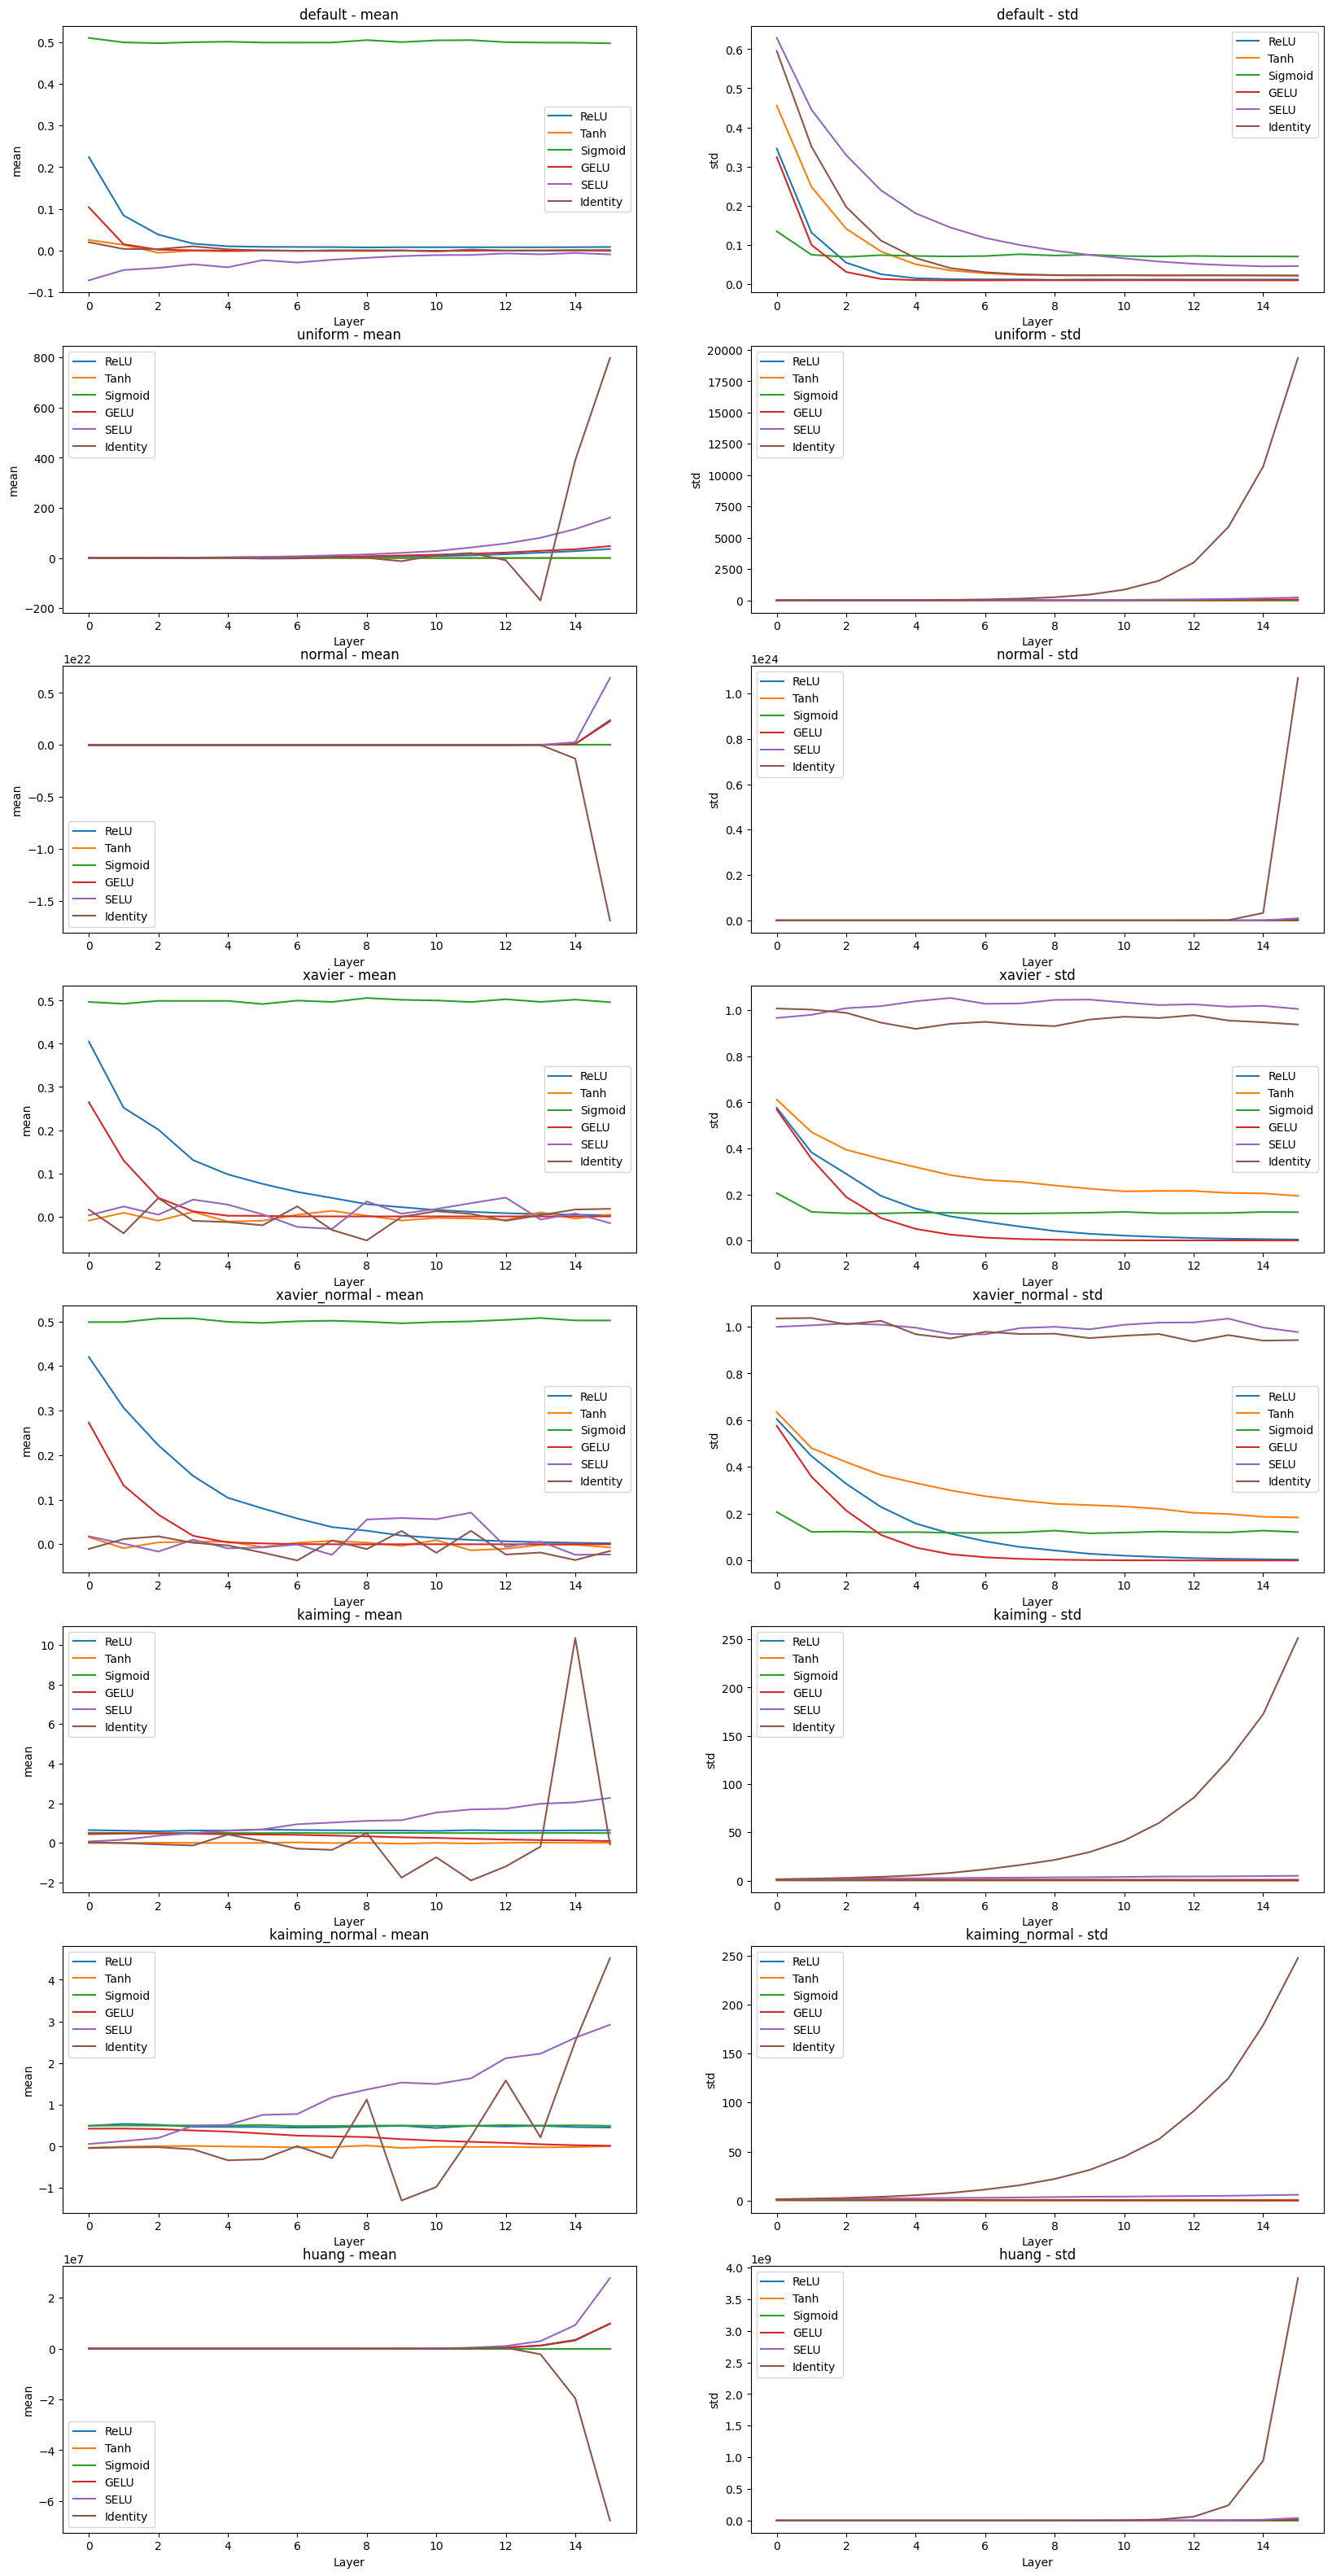

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
class DemoModel(nn.Module):
    def __init__(self,depth, activation, dim=1024, normalize=False):
        super().__init__()
        self.depth = depth
        self.activation = activation
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(dim, dim), 
                nn.LayerNorm(dim) if normalize else nn.Identity()
            )
            for _ in range(depth)])

    def forward(self, x):
        stats = []
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
            stats.append({'mean': x.mean().item(), 
                          'std': x.std().item()})
        return x, stats
depth = 16
dim = 1024
normalize = False
activations = [nn.ReLU(), nn.Tanh(), nn.Sigmoid(), nn.GELU(), nn.SELU(), nn.Identity()]
init_funcs = [None, uniform, normal, xavier, xavier_normal, kaiming, kaiming_normal, huang]
fig, axs = plt.subplots(len(init_funcs), 2, figsize=(20, 5*len(init_funcs)))
for activation in activations:
    for init_func, ax_row in zip(init_funcs, axs):
        model = DemoModel(depth=depth, activation=activation, dim=dim, normalize=normalize)
        if init_func is not None:
            init_func(model)
        name = 'default' if init_func is None else init_func.__name__
        x = torch.randn(dim)
        output, stats = model(x)
        stats = {key: [s[key] for s in stats] for key in stats[0]}
        for key, ax in zip(stats.keys(), ax_row):
            ax.plot(stats[key], label=activation.__class__.__name__)
            ax.set_title(f'{name} - {key}')
            ax.set_xlabel('Layer')
            ax.set_ylabel(f'{key}')
            ax.legend()
plt.show()

Our plots indicate that in deep networks, the stability of activations generally holds until deeper layers are reached, where instability begins to increase. This highlights the challenges faced in training deeper neural networks. However, there is other ways of stabilizing the magnitudes in your model like normalization which can mitigate some of the issues.

Determining the optimal initialization strategy for complex neural network models is an empirical endeavor. For insights into which strategies performed best in our tests, please refer to the cell below.

In [ ]:
for train_func, histories in results:
    print(f'Perplexity for {train_func}')
    for name, perplexity in sorted(histories, key=lambda x: x[1]):
        print(f'{perplexity:.1f} - Perplexity for {name} initialization')
    print("*"*50)
    print()

Perplexity for fixed_window
271.4 - Perplexity for xavier_normal initialization
272.1 - Perplexity for huang initialization
272.9 - Perplexity for uniform initialization
274.3 - Perplexity for xavier initialization
282.0 - Perplexity for kaiming_normal initialization
282.0 - Perplexity for kaiming initialization
336.5 - Perplexity for None initialization
1426.9 - Perplexity for normal initialization
**************************************************

Perplexity for rnn
228.9 - Perplexity for kaiming_normal initialization
229.4 - Perplexity for kaiming initialization
238.5 - Perplexity for None initialization
269.9 - Perplexity for huang initialization
274.2 - Perplexity for xavier initialization
276.5 - Perplexity for uniform initialization
277.0 - Perplexity for xavier_normal initialization
363.6 - Perplexity for normal initialization
**************************************************

